# Ноутбук с семинаром и домашним заданием для факультативного курса по машинному обучению, проводимому в НИТУ МИСИС.
**Темы:** кластеризация, понижение размерности, визуализация и оценка зависимости

**Автор:** Братчиков Сергей (tg: hivaze)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder

# Датасет
Будем использовать здесь датасет - **Alcohol Effects On Study**, датасет для задачи регрессии.
Ссылка на источник: https://www.kaggle.com/datasets/whenamancodes/alcohol-effects-on-study?select=Maths.csv

Датасет описывает успеваемость учащихся на экзаменах по математике и языку в средней школе двух португальских школ. Атрибуты данных включают оценки учащихся, демографические, социальные и школьные особенности, и они были собраны с использованием школьных отчетов и анкет.
Так же тут представлены данные о частоте употребления алкоголя учащимися, что можно использовать для оценки влияния этого фактора на оценку.

Оригинальной задачей является регрессия для определения оценки (колонки G1, G2, G3).
Но здесь мы перейдем к задаче классификации путем бинаризации колонки G3 (финальная оценка) на 5 категорий.

Однако мы мы не станем здесь заниматься решением задачи классификации или регрессии, а попробуем кластеризировать описания студентов и посмотреть как наш результат будет соотноситься с оригинальной разметкой классов.

Датасет содержит 30 фичей (колонок) и 1044 строк

Помимо этого мы попробуем все визуализировать, используя понижение размерности


In [2]:
dataset = pd.read_csv('data/exams_and_alcohol.csv')
dataset.drop(['G1', 'G2'], axis=1, inplace=True)
target_col = 'G3'

### Перейдем к самим датафреймам

Информация о фичах, как видно здесь нет пустых фичей, названия фичей хорошо говорят о том что в них содержится

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

#### Описание фичей на английском

| Колонка    	 | Описание                                                                                                                                               	    |
|--------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| school     	 | student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)                                                                          	 |
| sex        	 | student's sex (binary: 'F' - female or 'M' - male)                                                                                                        	 |
| age        	 | student's age (numeric: from 15 to 22)                                                                                                                    	 |
| address    	 | student's home address type (binary: 'U' - urban or 'R' - rural)                                                                                          	 |
| famsize    	 | family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)                                                                                	 |
| Pstatus    	 | parent's cohabitation status (binary: 'T' - living together or 'A' - apart)                                                                               	 |
| Medu       	 | mother's education (numeric: 0 - none,  1 - primary education (4th  grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“  higher education) 	 |
| Fedu       	 | father's education (numeric: 0 - none,  1 - primary education (4th  grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“  higher education) 	 |
| Mjob       	 | mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')                          	 |
| Fjob       	 | father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')                          	 |
| reason     	 | reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')                                              	 |
| guardian   	 | student's guardian (nominal: 'mother', 'father' or 'other')                                                                                               	 |
| traveltime 	 | home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)                                              	 |
| studytime  	 | weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)                                                          	 |
| failures   	 | number of past class failures (numeric: n if 1<=n<3, else 4)                                                                                              	 |
| schoolsup  	 | extra educational support (binary: yes or no)                                                                                                             	 |
| famsup     	 | family educational support (binary: yes or no)                                                                                                            	 |
| paid       	 | extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)                                                                     	 |
| activities 	 | extra-curricular activities (binary: yes or no)                                                                                                           	 |
| nursery    	 | attended nursery school (binary: yes or no)                                                                                                               	 |
| higher     	 | wants to take higher education (binary: yes or no)                                                                                                        	 |
| internet   	 | Internet access at home (binary: yes or no)                                                                                                               	 |
| romantic   	 | with a romantic relationship (binary: yes or no)                                                                                                          	 |
| famrel     	 | quality of family relationships (numeric: from 1 - very bad to 5 - excellent)                                                                             	 |
| freetime   	 | free time after school (numeric: from 1 - very low to 5 - very high)                                                                                      	 |
| goout      	 | going out with friends (numeric: from 1 - very low to 5 - very high)                                                                                      	 |
| Dalc       	 | workday alcohol consumption (numeric: from 1 - very low to 5 - very high)                                                                                 	 |
| Walc       	 | weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)                                                                                 	 |
| health     	 | current health status (numeric: from 1 - very bad to 5 - very good)                                                                                       	 |
| absences   	 | number of school absences (numeric: from 0 to 93)                                                                                                         	 |
| exam   	     | Type of exam (math and language)                                                                                                        	                   |

#### Семлп из датасета (случайные 5 объектов)

In [4]:
dataset.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,exam
283,GP,M,16,U,GT3,T,3,3,at_home,other,...,no,5,3,3,1,3,2,4,10,math
738,GP,M,16,U,LE3,A,4,4,teacher,health,...,no,4,1,3,3,5,5,18,7,language
607,MS,F,17,R,LE3,A,2,1,services,other,...,yes,5,3,3,1,2,2,5,12,math
112,GP,F,16,U,GT3,T,2,2,at_home,other,...,no,3,1,2,1,1,5,12,10,math
897,GP,M,18,R,LE3,T,3,3,other,services,...,yes,4,3,3,1,3,5,8,5,language


#### Давайте избавимся от текстовых фичей
Будем использовать LabelEncoder из sklearn

In [5]:
text_columns = [column for column in dataset.columns if dataset[column].dtype == object] # один из способов найти текстовые колонки в датасете
text_columns[:5]

['school', 'sex', 'address', 'famsize', 'Pstatus']

In [6]:
# Можете взять себе этот прием на заметку, LabelEncoder фититься только на одну колонку, поэтому мы создаем словарь где будем хранить все используемые кодировщики
label_encoders = defaultdict(LabelEncoder)
transformed_dataset = dataset.apply(lambda x: label_encoders[x.name].fit_transform(x) if x.name in text_columns else x)
transformed_dataset.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,exam
580,1,1,19,0,0,1,1,1,2,2,...,0,4,4,4,3,3,5,4,10,1
970,0,0,17,1,0,1,2,2,2,2,...,1,4,2,2,1,1,3,12,9,0
104,0,1,15,1,0,0,3,4,3,2,...,0,5,4,4,1,1,1,0,16,1
497,1,1,17,1,0,1,3,3,3,0,...,0,5,4,5,3,4,5,0,10,1
152,0,1,16,1,1,1,2,2,3,3,...,0,2,3,3,2,2,2,4,11,1


#### Посмотрим на распределния фичей в датасете
Это нужно для понимания в каких фичах могут быть выбросы, общую форму распредления

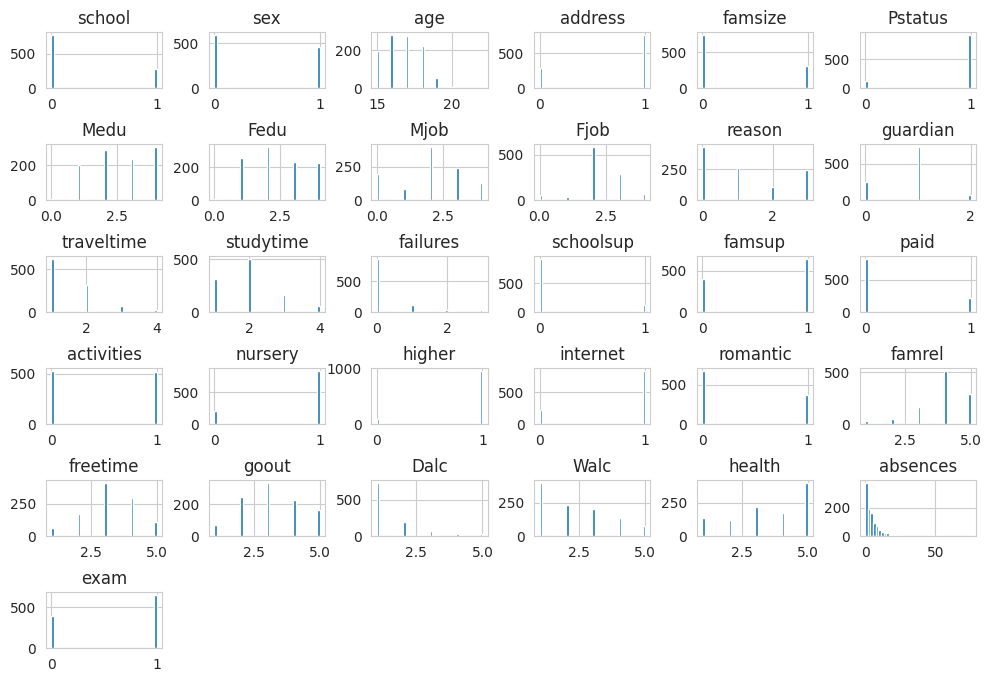

In [7]:
transformed_dataset.drop(target_col, axis=1).hist(bins=40, figsize=(12,8))
plt.subplots_adjust(hspace=1, wspace=0.4) # добавим места между графиками, чтобы не накладывались
plt.show()

#### Теперь посмотрим на некоторые зависимости между фичами (для интереса)
sex 0 - женщины, 1 - мужчины

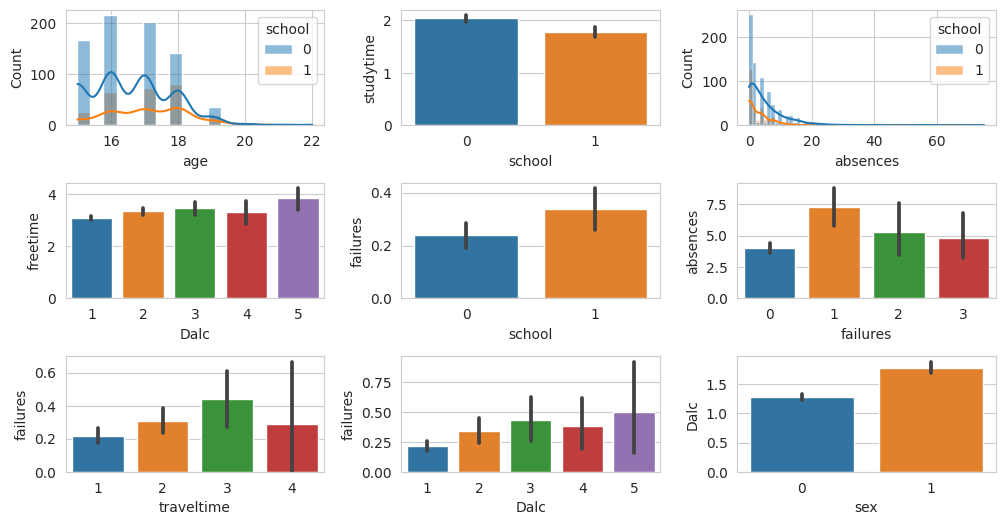

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(12, 6))
sns.histplot(data=transformed_dataset, x='age', hue='school', kde=True, ax=axes[0][0])
sns.barplot(data=transformed_dataset, x='school', y='studytime', ax=axes[0][1])
sns.histplot(data=transformed_dataset, x='absences', hue='school', kde=True, ax=axes[0][2])
sns.barplot(data=transformed_dataset, x='Dalc', y='freetime', ax=axes[1][0])
sns.barplot(data=transformed_dataset, x='school', y='failures', ax=axes[1][1])
sns.barplot(data=transformed_dataset, x='failures', y='absences', ax=axes[1][2])
sns.barplot(data=transformed_dataset, x='traveltime', y='failures', ax=axes[2][0])
sns.barplot(data=transformed_dataset, x='Dalc', y='failures', ax=axes[2][1])
sns.barplot(data=transformed_dataset, x='sex', y='Dalc', ax=axes[2][2])
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

### Домашнее задание (простое, обязательно)
Какие выводы вы можете сделать глядя на эти графики? Опишите ваши мысли и что интересного вы заметили. (до 5 пунктов)

[ПИСАТЬ ТУТ]

#### Посмотрим на распределение таргета
Напоминаю что таргет - некоторый грейд в 20ти бальной системе

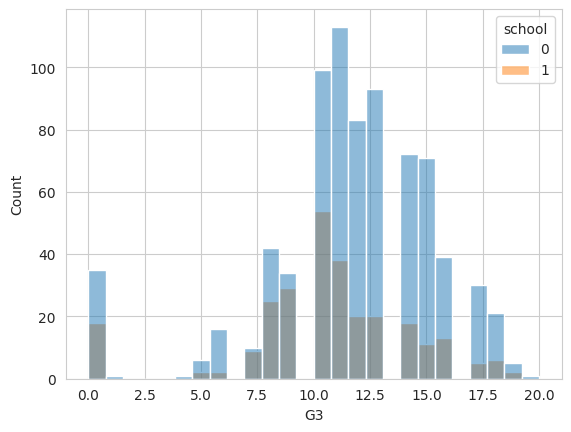

In [9]:
sns.histplot(data=transformed_dataset, x=target_col, hue='school') # мотрим распределение оценки (таргета) от школы
plt.show()

Чтож можно заметить что он нормально распределен, поэтому давайте примерно на глаз создадим 5 классов - грубо говоря переведем таргет в 5тибальную систему

In [10]:
new_target = pd.cut(transformed_dataset[target_col], bins=5, labels=['кретин', 'пересдача', 'удовл', 'хорошо', 'отлично'], ordered=False)
new_target.value_counts() # строит словарь частотности значений в колонке

удовл        470
хорошо       337
пересдача    112
отлично       70
кретин        55
Name: G3, dtype: int64

In [11]:
transformed_dataset[target_col] = new_target # обновляем столбец таргета

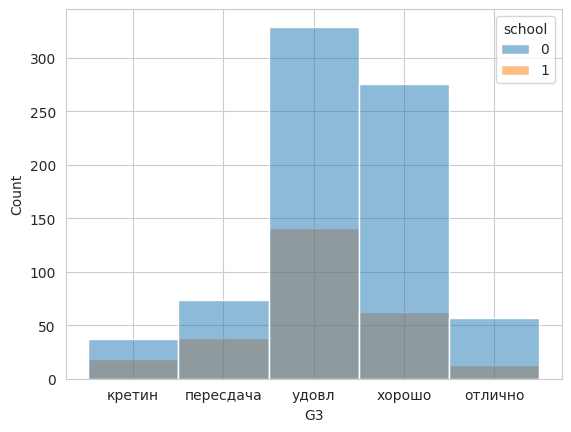

In [12]:
sns.histplot(data=transformed_dataset, x=target_col, hue='school') # мотрим распределение оценки (таргета) от школы
plt.show()

## Кластеризация

In [13]:
features_dataset = transformed_dataset.drop(target_col, axis=1) # делаем версию датасета без колонки таргета
features_dataset.shape, transformed_dataset.shape # убеждаемся что удалили

((1044, 31), (1044, 32))

### Kmeans
Выберем оптимальное количество кластеров методом локтя

Но для начала давайте научимся вычислять лосс Kmeans - сумму квадратов расстояний от центройда до каждого объекта

In [14]:
km = KMeans(n_clusters=3, random_state=228, verbose=1, n_init=3) # включаем verbose для отображения хода обучения, выбираем 3 кластера просто для проверки
km.fit(features_dataset) # нужно сделать фит на данных, он произойдет 3 раза и выберется лучший вариант
km.inertia_

Initialization complete
Iteration 0, inertia 58326.0.
Iteration 1, inertia 33440.29236540494.
Iteration 2, inertia 31989.526997094163.
Iteration 3, inertia 31900.68935115069.
Iteration 4, inertia 31897.223438531262.
Iteration 5, inertia 31888.960818507636.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 47021.0.
Iteration 1, inertia 30849.144395908912.
Iteration 2, inertia 30625.074141994523.
Iteration 3, inertia 30508.409805865344.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 44808.0.
Iteration 1, inertia 30709.914033481266.
Iteration 2, inertia 30673.07723034051.
Converged at iteration 2: strict convergence.


30508.409805865347

### Домашнее задание (сложнее, обязательно)
Допишите функцию вычисления лосса модели KMeans

In [15]:
def calc_kmeans_loss(km: KMeans) -> float:

    if not hasattr(km, 'inertia_'):
        print('Модель не зафичена, сначала fit()')
        return None

    sse = 0 ## sum of squared errors

    centroids = km.cluster_centers_ # shape - [k, n_features]
    predicted_clusters = # [ВАШ КОД]

    for i, x in features_dataset.iterrows():
        predicted_cluster = predicted_clusters[i]
        cluster_center = centroids[predicted_cluster]

        sse += # [ВАШ КОД]

    return sse

Если следующая ячейка выполнилась без ошибок - вы справились с заданием

In [16]:
assert abs(calc_kmeans_loss(km) - km.inertia_) < 1e-8, "Не получилось, переделай" # Проверка на правильность работы функции

### Домашнее задание (сложное, необязательно)
Допишите класс собственной реализации KMeans.
Важно: необязательно следовать тому коду который написал я, можете переписать его полностью, главное чтобы ваш класс наследовался от BaseEstimator, ClusterMixin и имел параметр k.
Наследование от BaseEstimator, ClusterMixin дает возможность использовать ваш класс с библиотекой sklearn и многими другими библиотеками.

Что делать:
Шаг 1: Выберите количество кластеров k
Шаг 2: Выберите k случайных точек из данных в качестве центроидов.
Шаг 3: Назначьте все точки ближайшему центроиду кластера.
Шаг 4: Пересчитайте центроиды вновь образованных кластеров.
Шаг 5: Повторите шаги 3 и 4.

In [17]:
class MySuperCoolKMeans(BaseEstimator, ClusterMixin):

    def __init__(self, k=5, n_iter=30, random_state=None):
        self.k = k
        self.n_iter = n_iter
        self.random_state = int(np.random.rand() * 2**32) if not random_state else random_state
        self.centroids = None

    def init_random_centroids(self, X):
        self.centroids = # [ВАШ КОД]

    def recalculate_centroids(self, X, clusters):
        # [ВАШ КОД]
        return sse

    def fit(self, X, y=None):
        self.init_random_centroids(X)
        for i in tqdm(range(self.n_iter)):
            print(f'Начало итерации {i}...')
            # [ВАШ КОД]
            print(f'Итерация {i} завершена, лосс {[ВАШ КОД]}')
        return self

    def predict(self, X):
        # [ВАШ КОД]
        return clusters

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)

У вас должно выйти что-то похожее по качеству и скорости

In [18]:
%%time
MySuperCoolKMeans(k=4, n_iter=8, random_state=32).fit(features_dataset).centroids

100%|██████████| 8/8 [00:00<00:00, 260.82it/s]

Начало итерации 0...
Итерация 0 завершена, лосс 36202.79443086222
Начало итерации 1...
Итерация 1 завершена, лосс 33773.45703807041
Начало итерации 2...
Итерация 2 завершена, лосс 31993.21504626824
Начало итерации 3...
Итерация 3 завершена, лосс 31067.146687312044
Начало итерации 4...
Итерация 4 завершена, лосс 30955.11092936512
Начало итерации 5...
Итерация 5 завершена, лосс 30652.721715501808
Начало итерации 6...
Итерация 6 завершена, лосс 30498.663986979096
Начало итерации 7...
Итерация 7 завершена, лосс 30363.89882298381
CPU times: user 36.7 ms, sys: 176 µs, total: 36.9 ms
Wall time: 35.3 ms


array([[ 0.03797468,  0.39240506, 17.25316456,  0.81012658,  0.32911392,
         0.79746835,  2.79746835,  2.59493671,  2.10126582,  2.26582278,
         1.25316456,  1.02531646,  1.48101266,  1.70886076,  0.56962025,
         0.12658228,  0.64556962,  0.26582278,  0.43037975,  0.81012658,
         0.86075949,  0.93670886,  0.48101266,  3.79746835,  3.20253165,
         3.26582278,  1.84810127,  2.74683544,  3.53164557, 20.13924051,
         0.39240506],
       [ 0.4368932 ,  0.40776699, 16.93851133,  0.58899676,  0.31067961,
         0.92880259,  1.59546926,  1.63754045,  1.28478964,  2.12297735,
         0.73462783,  0.83495146,  1.77669903,  1.82847896,  0.38511327,
         0.07443366,  0.51132686,  0.14563107,  0.4433657 ,  0.74110032,
         0.84789644,  0.65695793,  0.35598706,  3.94822006,  3.37540453,
         3.31067961,  1.50161812,  2.39482201,  3.53721683,  1.30744337,
         0.69255663],
       [ 0.17117117,  0.43843844, 16.26726727,  0.82282282,  0.25825826,
       

Возврашаемся к методу локтя

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


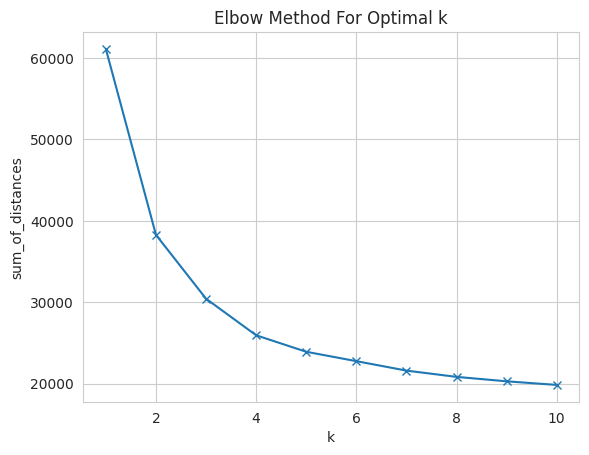

In [19]:
sum_of_distances = []
k_range = range(1, 11)
for k in tqdm(k_range):
    km = KMeans(n_clusters=k, random_state=228)
    km = km.fit(transformed_dataset.drop(target_col, axis=1))

    # теперь просто вычисляем лосс и записываем его
    sum_of_distances.append(calc_kmeans_loss(km))

plt.plot(k_range, sum_of_distances, 'x-')
plt.xlabel('k')
plt.ylabel('sum_of_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Видно что оптимальным параметром k можно назвать 4, далее скорость падения лосса уже не так интересна

In [20]:
km = KMeans(n_clusters=4, random_state=228)
cluster_marks = km.fit_predict(transformed_dataset.drop(target_col, axis=1))
pd.Series(cluster_marks).value_counts() # давайте используем прием с подсчетом значений, чтобы понять распределение

2    564
0    372
3    103
1      5
dtype: int64

#### Давайте визуализируем наш результат (TSVD и PCA)
Так как невозможно отобразить пространство размерности 30, то следует его понизить до 2 или 3

In [21]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE

In [22]:
reduced_dataset = TruncatedSVD(n_components=2).fit_transform(features_dataset)
reduced_dataset.shape # как видно размерность фичей уменьшилась до 2

(1044, 2)

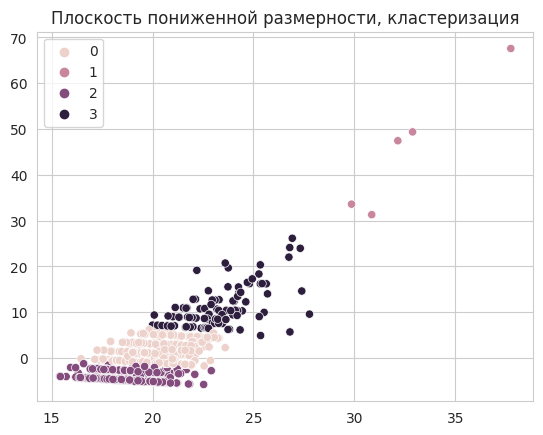

In [23]:
sns.scatterplot(x=reduced_dataset[:, 0], y=reduced_dataset[:, 1], hue=cluster_marks)
plt.title("Плоскость пониженной размерности, кластеризация")
plt.show()

А теперь давайте попробуем посмотреть как выглядит реальная разметка классов

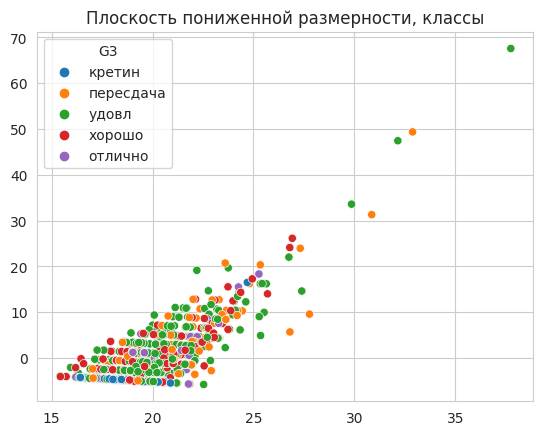

In [24]:
sns.scatterplot(x=reduced_dataset[:, 0], y=reduced_dataset[:, 1], hue=transformed_dataset[target_col])
plt.title("Плоскость пониженной размерности, классы")
plt.show()

In [25]:
reduced_dataset = TruncatedSVD(n_components=3).fit_transform(features_dataset)
reduced_dataset.shape # как видно размерность фичей уменьшилась до 3

(1044, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


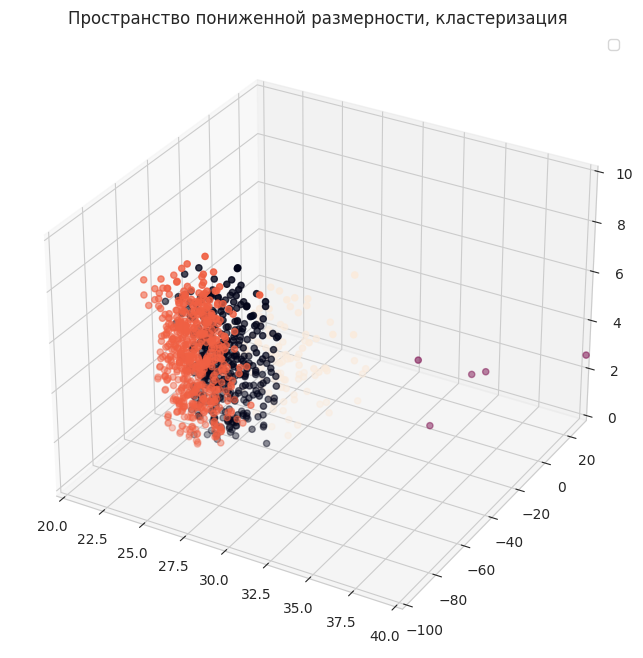

In [26]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Пространство пониженной размерности, кластеризация")
ax.scatter(xs=reduced_dataset[:, 0], ys=reduced_dataset[:, 1], zs=reduced_dataset[:, 2], c=cluster_marks)
ax.legend(loc="best")
ax.set_xlim(20,40)
ax.set_ylim(-100,30)
ax.set_zlim(0,10)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


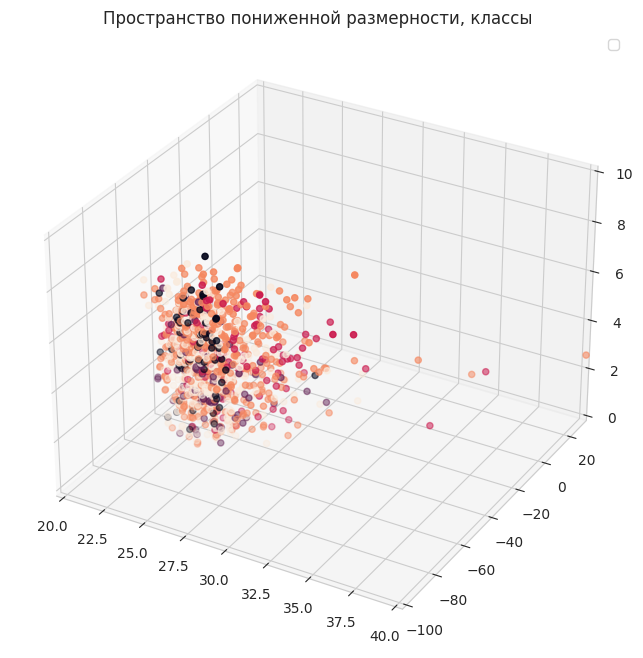

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Пространство пониженной размерности, классы")
_encoded_target = LabelEncoder().fit_transform(transformed_dataset[target_col])
ax.scatter(xs=reduced_dataset[:, 0], ys=reduced_dataset[:, 1], zs=reduced_dataset[:, 2], c=_encoded_target)
ax.legend(loc="best")
ax.set_xlim(20,40)
ax.set_ylim(-100,30)
ax.set_zlim(0,10)
plt.show()

Как можно заметить SVD плохо справляется с понижением размерности - классы перемешиваются, это связано с тем что линейный алгоритм вероятно для решения задачи классификации на этом датасете даст плохой результат, можете сами это проверить

### Домашнее задание (простое, необзятальено)
Замените TruncatedSVD на PCA и посмотрите в чем разница при построении графиков, кратко опишите в чем разница с TruncatedSVD.
Возможно вам придется поменять set_xlim, set_ylim и set_zlim в 3д визуализации

[ПИСАТЬ ТУТ]

#### Теперь попробуем визуализацию с TSNE


In [28]:
reduced_dataset = TSNE(n_components=2, n_iter=5000, n_jobs=2).fit_transform(features_dataset)
reduced_dataset.shape # как видно размерность фичей уменьшилась до 2

/home/hivaze/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hivaze/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1044, 2)

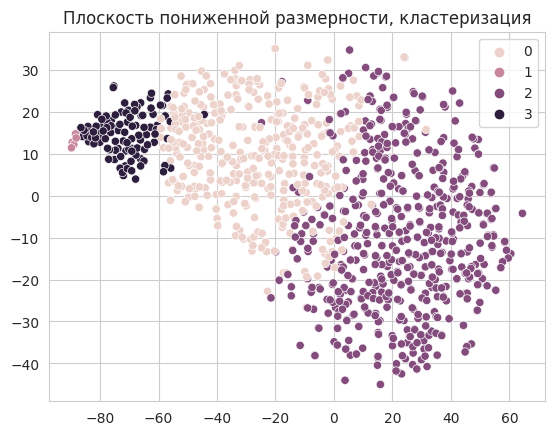

In [29]:
sns.scatterplot(x=reduced_dataset[:, 0], y=reduced_dataset[:, 1], hue=cluster_marks)
plt.title("Плоскость пониженной размерности, кластеризация")
plt.show()

Как можно заметить на такой визуализации, уже гораздо лучше видно поведение KMeans. Т.е. лучше видно кластеры которые можно описать диаграммами Вороного, но напоминаю что кластеризацию мы делали в более высокоразмерном пространстве.

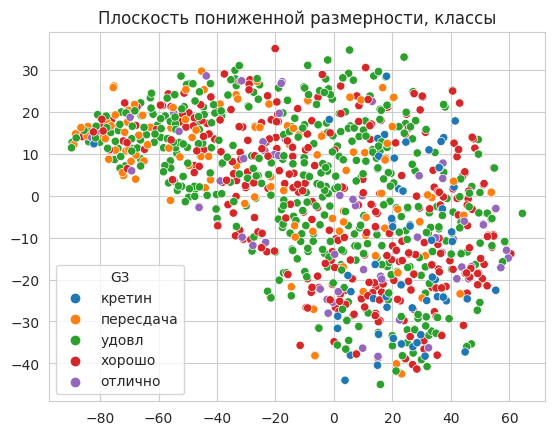

In [30]:
sns.scatterplot(x=reduced_dataset[:, 0], y=reduced_dataset[:, 1], hue=transformed_dataset[target_col])
plt.title("Плоскость пониженной размерности, классы")
plt.show()

А вот здесь видно, что линейной разделимости не получилось, что доказывает что линейные модели не способны справиться с этой задачей, однако подходы на основе деревьев и нейронок вполне смогут дать какойто результат

In [31]:
reduced_dataset = TSNE(n_components=3, n_iter=5000, n_jobs=2).fit_transform(features_dataset)
reduced_dataset.shape # как видно размерность фичей уменьшилась до 3

/home/hivaze/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hivaze/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1044, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


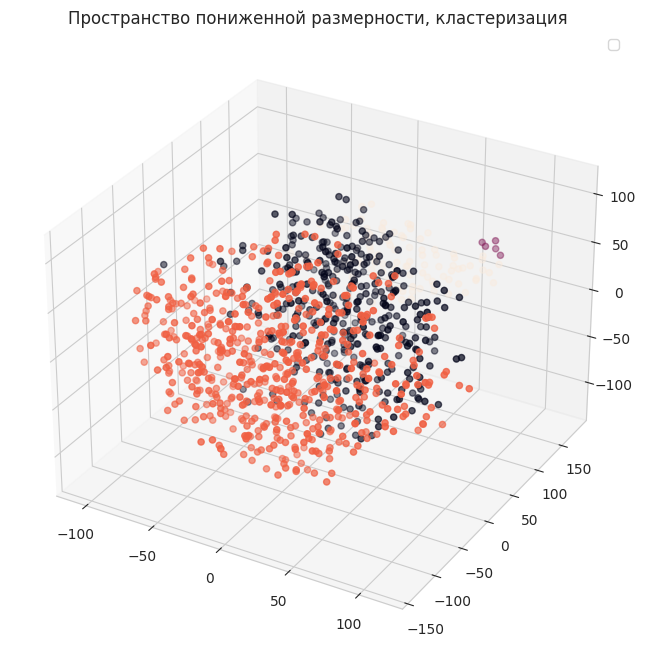

In [32]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Пространство пониженной размерности, кластеризация")
ax.scatter(xs=reduced_dataset[:, 0], ys=reduced_dataset[:, 1], zs=reduced_dataset[:, 2], c=cluster_marks)
ax.legend(loc="best")
plt.show()

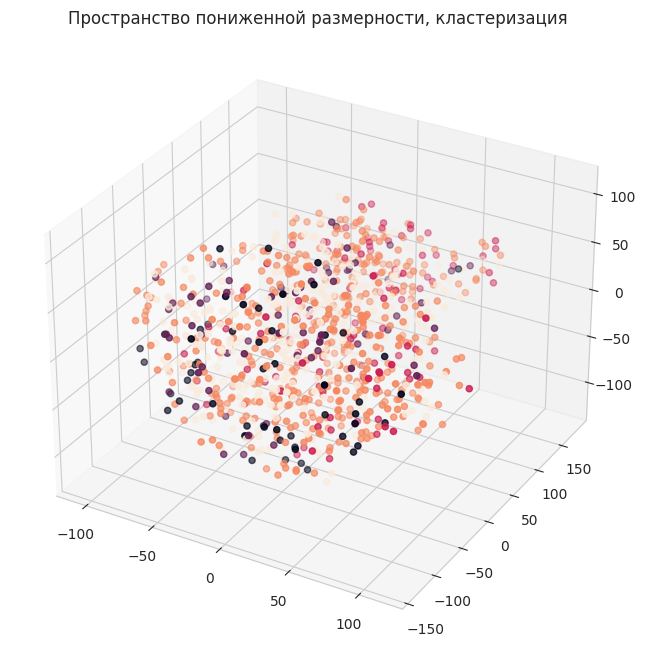

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Пространство пониженной размерности, кластеризация")
_encoded_target = LabelEncoder().fit_transform(transformed_dataset[target_col])
ax.scatter(xs=reduced_dataset[:, 0], ys=reduced_dataset[:, 1], zs=reduced_dataset[:, 2], c=_encoded_target)
plt.show()

Впринципе можно увидеть что оригинальные классы имеют небольшую тендецию к разделению в прострнаствах более высокой размерности, они немного группируются вместе

### DBSCAN

Давайте для начала посчитаем минимальное и максимальное расстояние между объектами в датасете

In [34]:
from sklearn.metrics import pairwise_distances

In [35]:
distance_matrix = pairwise_distances(features_dataset)
distance_matrix.shape

(1044, 1044)

In [36]:
print('Максимальное расстояние между объектами: ', distance_matrix.max())
_masked_diagonal = distance_matrix.copy()
np.fill_diagonal(_masked_diagonal, np.inf) # на диагонали у нас стоят нули, а они нам помешают
print('Минимальное расстояние между объектами: ', _masked_diagonal.min())

Максимальное расстояние между объектами:  75.59100475585703
Минимальное расстояние между объектами:  1.0


Можно посмотреть на треугольную матрицу и распределение расстояний внутри нее

In [50]:
pd.Series(distance_matrix.reshape(-1)[np.triu_indices(distance_matrix.shape[0], k=1)[1]]).describe()

count   544,446.00000
mean          8.27991
std           4.74638
min           2.23607
25%           6.55744
50%           7.28011
75%           8.24621
max          71.24605
dtype: float64

In [101]:
dbs = DBSCAN(eps=4, min_samples=4, p=2, n_jobs=2)
cluster_marks = dbs.fit_predict(features_dataset)
pd.Series(cluster_marks).value_counts()

 0    742
-1    298
 1      4
dtype: int64

### Домашнее задание (простое, обязательно)
Поиграйтесь с параметрами DBSCAN, на основе статистики о расстояниях, можете легко убедиться насколько их тяжело подбирать чтобы получить хоть какойто значимый результат. Сделайте выводы (необязательно добиваться значимого результата).

[ПИСАТЬ ТУТ]

Такое поведение на самом деле хорошо объясняется тем, какие у нас фичи (они все имеют слишком различные пространства), давайте попробуем сделать скейлинг фичей и посмотреть станет ли лучше

In [137]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [158]:
scaled_dataset = MinMaxScaler().fit_transform(features_dataset)
pd.DataFrame(scaled_dataset).describe() # убеждаемся что для каждой фичи min=0, а max=1

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
count,"1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000",...,"1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000","1,044.00000"
mean,0.26054,0.43391,0.24658,0.72701,0.29310,0.88410,0.65086,0.59698,0.50694,0.56154,...,0.79215,0.35536,0.73396,0.55029,0.53903,0.12356,0.32112,0.63578,0.05913,0.62165
std,0.43914,0.49585,0.17714,0.44571,0.45540,0.32026,0.28123,0.27498,0.31120,0.21588,...,0.40597,0.47885,0.23335,0.25788,0.28814,0.22793,0.32128,0.35618,0.08280,0.48521
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.14286,0.00000,0.00000,1.00000,0.50000,0.25000,0.25000,0.50000,...,1.00000,0.00000,0.75000,0.50000,0.25000,0.00000,0.00000,0.50000,0.00000,0.00000
50%,0.00000,0.00000,0.28571,1.00000,0.00000,1.00000,0.75000,0.50000,0.50000,0.50000,...,1.00000,0.00000,0.75000,0.50000,0.50000,0.00000,0.25000,0.75000,0.02667,1.00000
75%,1.00000,1.00000,0.42857,1.00000,1.00000,1.00000,1.00000,0.75000,0.75000,0.75000,...,1.00000,1.00000,1.00000,0.75000,0.75000,0.25000,0.50000,1.00000,0.08000,1.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [159]:
dbs = DBSCAN(eps=1.2, min_samples=3, n_jobs=2)
cluster_marks = dbs.fit_predict(scaled_dataset)
pd.Series(cluster_marks).value_counts()

-1     773
 5      37
 15     26
 2      24
 6      18
 26     10
 14      9
 0       8
 3       8
 30      7
 1       7
 35      7
 18      7
 31      6
 19      6
 32      5
 29      5
 20      5
 17      4
 8       4
 34      4
 22      4
 33      4
 16      4
 25      4
 12      4
 11      4
 13      4
 10      4
 9       4
 4       4
 24      3
 36      3
 21      3
 27      3
 28      3
 37      3
 7       3
 23      3
dtype: int64

Видно, что стало лучше? Ненамного, поэтому DBSCAN изза сложности настройки зачастую применяют после понижения размерности, в основном нелинейными методами вроде TSNE. Но стоит и отметить, что данные у нас здесь не самые удачные и их мало.

### А теперь давайте убедимся в правильности наших выводов о нелинейности самой задачи
Не заморачиваясь с настройкой моделей и разбиением на трейн и тест

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [134]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000).fit(features_dataset, _encoded_target)
print(classification_report(_encoded_target, lr_model.predict(features_dataset)))

              precision    recall  f1-score   support

           0       0.39      0.93      0.55        55
           1       0.19      0.61      0.29        70
           2       0.34      0.63      0.45       112
           3       0.70      0.34      0.46       470
           4       0.52      0.39      0.45       337

    accuracy                           0.44      1044
   macro avg       0.43      0.58      0.44      1044
weighted avg       0.55      0.44      0.45      1044



In [135]:
rf_model = RandomForestClassifier(max_depth=6, class_weight='balanced').fit(features_dataset, _encoded_target)
print(classification_report(_encoded_target, rf_model.predict(features_dataset)))

              precision    recall  f1-score   support

           0       0.56      0.98      0.71        55
           1       0.56      0.91      0.69        70
           2       0.72      0.81      0.76       112
           3       0.88      0.67      0.76       470
           4       0.71      0.73      0.72       337

    accuracy                           0.74      1044
   macro avg       0.68      0.82      0.73      1044
weighted avg       0.77      0.74      0.74      1044



Результаты на лицо (смотреть на f1 macro)

### Домашнее задание (простое, обязательно)
А теперь используя материалы пройденных на прошлых занятиях (подсказка: feature-importance), попробуйте отвестить на вопрос:
Влияет ли алкоголь на успеваемость?
Нужные фичи: Dalc, Walc

Пишите свой код в ячейках ниже. Тезисно ответ (да/нет) и в какой степени, какие фичи влияют больше всего кроме алкоголя:
[ПИСАТЬ ТУТ]